# 🏆 BA-04: Desempeño de Proveedores (LATAM)

Evaluación de OTD, calidad y lead time; cifras en USD.


In [1]:
# Configurar entorno del repositorio
import sys
from pathlib import Path
_candidates = [Path.cwd(), *Path.cwd().parents]
_repo_root = None
for _p in _candidates:
    if (_p / 'pyproject.toml').exists() or (_p / 'src').exists():
        _repo_root = _p
        break
if _repo_root is None:
    _repo_root = Path.cwd()
if str(_repo_root) not in sys.path:
    sys.path.insert(0, str(_repo_root))
print(f"✅ Entorno listo: {_repo_root}")

✅ Entorno listo: f:\GitHub\supply-chain-data-notebooks


In [2]:
# Imports y configuración de visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
sns.set(style='whitegrid')

data_out = _repo_root / 'data' / 'processed' / 'ba04_supplier_performance'
data_out.mkdir(parents=True, exist_ok=True)
print(f"💾 Salida: {data_out}")

💾 Salida: f:\GitHub\supply-chain-data-notebooks\data\processed\ba04_supplier_performance


---
id: "BA-04"
title: "Supplier Performance Analysis"
specialty: "Business Analytics"
process: "Source/Procure"
level: "Intermediate"
tags: ["suppliers","otd","quality","risk","latam"]
estimated_time_min: 45
---

## 🔧 Instalación de Librerías

```bash
# Opción 1: Instalar librerías individuales
pip install pandas numpy matplotlib seaborn pyarrow

# Opción 2: Instalar todo el entorno del proyecto
pip install -e .[core,notebooks,or]
```

**Librerías requeridas:**
- `pandas`, `numpy` - Análisis de datos
- `matplotlib`, `seaborn` - Visualizaciones
- `pyarrow` - Exportación Parquet

**Datasets generados/exportados:**
| Archivo | Descripción |
|---------|-------------|
| `supplier_kpis.parquet` | KPIs por proveedor |
| `supplier_score.parquet` | Score compuesto y recomendación |
| `supplier_performance.png` | Gráficos de desempeño |
| `supplier_kpi_bars.png` | Barras de KPIs |


In [3]:
# Validación rápida de librerías y entorno
import importlib
for lib in ["pandas", "numpy", "matplotlib", "seaborn", "pyarrow"]:
    m = importlib.import_module(lib)
    print(f'✅ {lib} versión: {m.__version__ if hasattr(m, "__version__") else "ok"}')
print('¡Entorno listo para ejecutar el notebook!')

✅ pandas versión: 2.3.3
✅ numpy versión: 2.3.3
✅ matplotlib versión: 3.10.7
✅ seaborn versión: 0.13.2
✅ pyarrow versión: 21.0.0
¡Entorno listo para ejecutar el notebook!


In [4]:
# Configuración de entorno y rutas
import sys
from pathlib import Path
_candidates = [Path.cwd(), *Path.cwd().parents]
_repo_root = None
for _p in _candidates:
    if (_p / 'pyproject.toml').exists() or (_p / 'src').exists():
        _repo_root = _p
        break
if _repo_root is None:
    _repo_root = Path.cwd()
if str(_repo_root) not in sys.path:
    sys.path.insert(0, str(_repo_root))
data_out = _repo_root / 'data' / 'processed' / 'ba04_supplier_performance'
data_out.mkdir(parents=True, exist_ok=True)
print(f'✅ Entorno y rutas configuradas: {data_out}')

✅ Entorno y rutas configuradas: f:\GitHub\supply-chain-data-notebooks\data\processed\ba04_supplier_performance


## 📋 Contexto de Negocio

Evaluar proveedores en LATAM considerando:
- Lead time (promedio y variabilidad)
- On-Time Delivery (OTD)
- % Rechazos de calidad
- Score compuesto para priorizar consolidación, renegociación o desarrollo

**Ejemplo de decisión:**
- Consolidar con proveedores de alto score
- Renegociar con score medio
- Desarrollar o reemplazar proveedores de bajo score

### 🎲 Generación de datos sintéticos

- Se simulan `n_orders` para `n_suppliers` en un periodo 2025.
- `expected_lead_time` ~ U[7, 20] días; `actual_lead_time` = esperado + N(0, 3).
- OTD (On-Time Delivery) se define como `actual_lead_time <= expected_lead_time`.
- `quality_reject` ~ Bernoulli(p=0.07) como tasa de rechazo típica de LATAM.
- `order_value_usd` en USD para homogeneidad y análisis económico.

Estos supuestos buscan un dataset robusto y realista para pruebas de KPIs.

In [5]:
# Generar datos sintéticos de órdenes y proveedores
import numpy as np
import pandas as pd
np.random.seed(42)

n_suppliers = 8
n_orders = 500
suppliers = [f'Proveedor_{i+1}' for i in range(n_suppliers)]

orders = pd.DataFrame({
    'order_id': np.arange(1, n_orders+1),
    'supplier': np.random.choice(suppliers, n_orders),
    'order_date': pd.to_datetime('2025-01-01') + pd.to_timedelta(np.random.randint(0, 330, n_orders), unit='D'),
    'expected_lead_time': np.random.randint(7, 21, n_orders),
    'actual_lead_time': lambda df: df['expected_lead_time'] + np.random.normal(0, 3, n_orders),
    'order_value_usd': np.round(np.random.uniform(500, 5000, n_orders), 2),
    'quality_reject': np.random.binomial(1, 0.07, n_orders),
})
orders['actual_lead_time'] = orders['expected_lead_time'] + np.random.normal(0, 3, n_orders)
orders['delivery_date'] = orders['order_date'] + pd.to_timedelta(orders['actual_lead_time'], unit='D')
orders['on_time'] = (orders['actual_lead_time'] <= orders['expected_lead_time']).astype(int)
print(orders.head())

   order_id     supplier order_date  expected_lead_time  actual_lead_time  \
0         1  Proveedor_7 2025-07-10                  17         20.632219   
1         2  Proveedor_4 2025-09-10                  18         19.857112   
2         3  Proveedor_5 2025-06-10                  19         17.625589   
3         4  Proveedor_7 2025-09-13                   8          6.926848   
4         5  Proveedor_3 2025-11-19                  16         14.818056   

   order_value_usd  quality_reject                 delivery_date  on_time  
0          2132.41               0 2025-07-30 15:10:23.688493014        0  
1          4374.81               0 2025-09-29 20:34:14.441795808        0  
2          1487.80               0 2025-06-27 15:00:50.892914200        1  
3          4885.46               0 2025-09-19 22:14:39.706355814        1  
4          4008.91               0 2025-12-03 19:38:00.030632009        1  


### 📊 Definición de KPIs y fórmulas

- `avg_lead_time`: promedio de `actual_lead_time` por proveedor.
- `std_lead_time`: desviación estándar de `actual_lead_time` (variabilidad del servicio).
- `otd_pct`: porcentaje de órdenes entregadas a tiempo (OTD).
- `quality_reject_pct`: porcentaje de órdenes rechazadas por calidad.
- `total_value_usd`: suma del valor de órdenes (USD).

#### Score compuesto (0–100)
Se prioriza menor lead time/variabilidad, mayor OTD, menor rechazo:

$Score = 0.25\cdot(100 - \overline{LT}) + 0.15\cdot(100 - \sigma_{LT}) + 0.35\cdot OTD + 0.25\cdot(100 - Rejects)$

- Ponderaciones ajustables según política de compras.
- Acciones recomendadas: `Consolidate (>=85)`, `Renegotiate (>=70)`, `Develop/Replace` (<70).

In [6]:
# Calcular KPIs por proveedor
kpi = orders.groupby('supplier').agg(
    total_orders = ('order_id', 'count'),
    avg_lead_time = ('actual_lead_time', 'mean'),
    std_lead_time = ('actual_lead_time', 'std'),
    otd_pct = ('on_time', 'mean'),
    quality_reject_pct = ('quality_reject', 'mean'),
    total_value_usd = ('order_value_usd', 'sum')
).reset_index()
kpi['otd_pct'] *= 100
kpi['quality_reject_pct'] *= 100
kpi = kpi.round({
    'avg_lead_time': 2,
    'std_lead_time': 2,
    'otd_pct': 1,
    'quality_reject_pct': 1,
    'total_value_usd': 2
})
print(kpi)

# Score compuesto (ponderado)
# Menor lead time y desviación, mayor OTD, menor %rechazo
kpi['score'] = (
    (100 - kpi['avg_lead_time']) * 0.25 +
    (100 - kpi['std_lead_time']) * 0.15 +
    kpi['otd_pct'] * 0.35 +
    (100 - kpi['quality_reject_pct']) * 0.25
)

# Clasificación
kpi['action'] = np.select(
    [kpi['score'] >= 85, kpi['score'] >= 70],
    ['Consolidate', 'Renegotiate'],
    default='Develop/Replace'
)
print(kpi[['supplier','score','action']])

# Exportar resultados
kpi.to_parquet(data_out / 'supplier_kpis.parquet', index=False)
kpi[['supplier','score','action']].to_parquet(data_out / 'supplier_score.parquet', index=False)
print(f"✅ KPIs y score exportados a {data_out}")

      supplier  total_orders  avg_lead_time  std_lead_time  otd_pct  \
0  Proveedor_1            71          13.10           5.92     50.7   
1  Proveedor_2            46          13.14           4.56     45.7   
2  Proveedor_3            64          12.91           5.58     54.7   
3  Proveedor_4            76          13.88           4.77     47.4   
4  Proveedor_5            51          13.82           5.06     39.2   
5  Proveedor_6            62          12.55           4.88     53.2   
6  Proveedor_7            58          12.89           4.48     43.1   
7  Proveedor_8            72          13.46           5.45     61.1   

   quality_reject_pct  total_value_usd  
0                 5.6        195920.66  
1                 2.2        122394.53  
2                 6.2        177869.84  
3                 6.6        221226.14  
4                 5.9        135514.23  
5                 6.5        169349.97  
6                 3.4        163855.61  
7                11.1        207

### 🧮 Cálculo y normalización

- Los porcentajes (`otd_pct`, `quality_reject_pct`) se escalan 0–100.
- Redondeo de métricas para presentación.
- Exportación en Parquet para uso en BI/ETL.

Nota: Las ponderaciones del score pueden ajustarse a drivers estratégicos (servicio vs calidad).

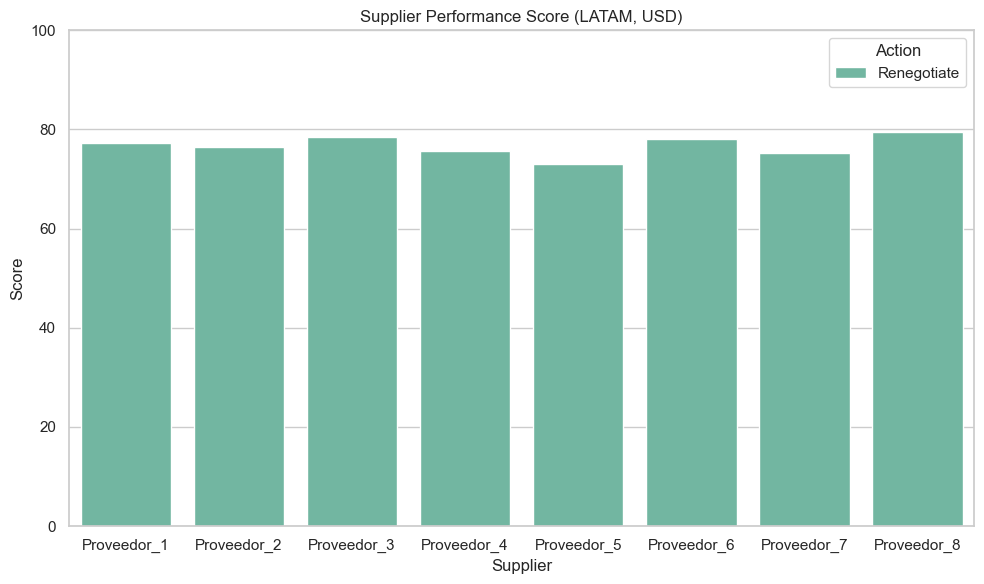

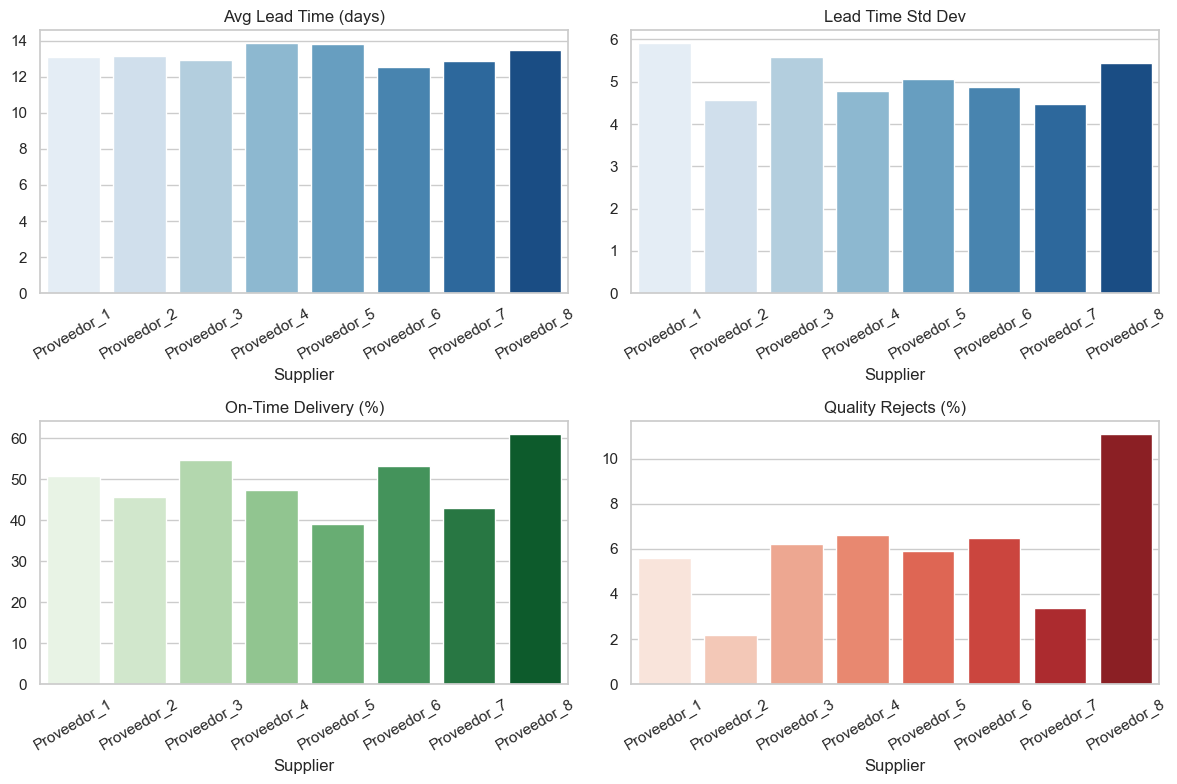

✅ Gráficos exportados a f:\GitHub\supply-chain-data-notebooks\data\processed\ba04_supplier_performance


In [7]:
# Visualización de desempeño y score
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(data=kpi, x='supplier', y='score', hue='action', palette='Set2')
plt.title('Supplier Performance Score (LATAM, USD)')
plt.ylabel('Score')
plt.xlabel('Supplier')
plt.ylim(0, 100)
plt.legend(title='Action')
plt.tight_layout()
plt.savefig(data_out / 'supplier_performance.png', dpi=150)
plt.show()

# Visualización de KPIs
fig, axes = plt.subplots(2,2, figsize=(12,8))
sns.barplot(data=kpi, x='supplier', y='avg_lead_time', ax=axes[0,0], palette='Blues')
axes[0,0].set_title('Avg Lead Time (days)')
sns.barplot(data=kpi, x='supplier', y='std_lead_time', ax=axes[0,1], palette='Blues')
axes[0,1].set_title('Lead Time Std Dev')
sns.barplot(data=kpi, x='supplier', y='otd_pct', ax=axes[1,0], palette='Greens')
axes[1,0].set_title('On-Time Delivery (%)')
sns.barplot(data=kpi, x='supplier', y='quality_reject_pct', ax=axes[1,1], palette='Reds')
axes[1,1].set_title('Quality Rejects (%)')
for ax in axes.flat:
    ax.set_xlabel('Supplier')
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.tight_layout()
plt.savefig(data_out / 'supplier_kpi_bars.png', dpi=150)
plt.show()
print(f"✅ Gráficos exportados a {data_out}")

### 📈 Visualizaciones e interpretación

- Gráfico 1: Score por proveedor con etiqueta de acción (consolidar/renegociar/desarrollar).
- Panel de KPIs: comparación de `avg_lead_time`, `std_lead_time`, `otd_pct`, `quality_reject_pct`.

Guía rápida:
- Menor lead time y desviación indican consistencia.
- Mayor OTD y menor rechazo indican cumplimiento y calidad.
- Use estos gráficos para priorizar sourcing y negociación en LATAM.

In [8]:
# Validación final: archivos y lógica
"""
Validaciones incluidas:
- Existencia de archivos exportados (Parquet y PNG)
- Dominio del score [0, 100]
- Clasificación en conjunto finito de acciones
Estas validaciones siguen el patrón del repositorio para asegurar reproducibilidad y calidad.
"""
import os
expected_files = [
    'supplier_kpis.parquet',
    'supplier_score.parquet',
    'supplier_performance.png',
    'supplier_kpi_bars.png'
]
for f in expected_files:
    assert (data_out / f).exists(), f"Missing: {f}"
    print(f"✅ {f} exists")
assert kpi['score'].between(0,100).all(), "Score out of bounds"
assert kpi['action'].isin(['Consolidate','Renegotiate','Develop/Replace']).all(), "Invalid action"
print(f"\n🎉 Notebook ejecutado exitosamente y validado")

✅ supplier_kpis.parquet exists
✅ supplier_score.parquet exists
✅ supplier_performance.png exists
✅ supplier_kpi_bars.png exists

🎉 Notebook ejecutado exitosamente y validado


## 🎯 Recomendaciones de Compras

Se proponen acciones basadas en umbrales:
- Consolidate: `score >= 85` y `otd_pct >= 90 - quality_reject_pct`
- Renegotiate: `70 <= score < 85` o variabilidad alta (`std_lead_time > 5`)
- Develop/Replace: `score < 70` o `quality_reject_pct > 8`

Además, se sugiere ponderar por `total_value_usd` para priorizar impacto económico.

In [9]:
# Generar tabla de recomendaciones basada en umbrales
rec_df = kpi.copy()
rec_df['recommendation'] = np.select(
    [
        (rec_df['score'] >= 85) & (rec_df['otd_pct'] >= (90 - rec_df['quality_reject_pct'])),
        (rec_df['score'] >= 70) | (rec_df['std_lead_time'] > 5)
    ],
    ['Consolidate', 'Renegotiate'],
    default='Develop/Replace'
)
rec_df = rec_df.sort_values(['recommendation','score','total_value_usd'], ascending=[True, False, False])

cols = ['supplier','score','otd_pct','quality_reject_pct','avg_lead_time','std_lead_time','total_value_usd','recommendation']
print(rec_df[cols].to_string(index=False))

# Exportar
rec_df[cols].to_parquet(data_out / 'supplier_recommendations.parquet', index=False)
print(f"✅ Recomendaciones exportadas a {data_out}")

   supplier   score  otd_pct  quality_reject_pct  avg_lead_time  std_lead_time  total_value_usd recommendation
Proveedor_8 79.4275     61.1                11.1          13.46           5.45        207149.76    Renegotiate
Proveedor_3 78.5305     54.7                 6.2          12.91           5.58        177869.84    Renegotiate
Proveedor_6 78.1255     53.2                 6.5          12.55           4.88        169349.97    Renegotiate
Proveedor_1 77.1820     50.7                 5.6          13.10           5.92        195920.66    Renegotiate
Proveedor_2 76.4760     45.7                 2.2          13.14           4.56        122394.53    Renegotiate
Proveedor_4 75.7545     47.4                 6.6          13.88           4.77        221226.14    Renegotiate
Proveedor_7 75.3405     43.1                 3.4          12.89           4.48        163855.61    Renegotiate
Proveedor_5 73.0310     39.2                 5.9          13.82           5.06        135514.23    Renegotiate
✅